In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as mno
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn import linear_model

In [2]:
#importing the database from the Kaggle competition
app_train = pd.read_csv("C:/data/application_train.csv")
print(app_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
None


In [3]:
#Easy summary of missing data
print(app_train.isna().sum())
missing_total = 100*(app_train.isnull().sum(axis = 1) > 0).sum()/len(app_train)
print("The percentage of rows with some missing values: ", missing_total,"%")

SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 122, dtype: int64
The percentage of rows with some missing values:  97.202701691972 %


In [4]:
#More useful summary of missing data
null=pd.DataFrame(app_train.isnull().sum(),columns=["Null Values"])
null["% Missing Values"]=(app_train.isna().sum()/len(app_train)*100)
null = null[null["% Missing Values"] > 0]
null.style.background_gradient(cmap='viridis',low =0.2,high=0.1)

,Null Values,% Missing Values
AMT_ANNUITY,12,0.003902
AMT_GOODS_PRICE,278,0.090403
NAME_TYPE_SUITE,1292,0.420148
OWN_CAR_AGE,202929,65.990810
OCCUPATION_TYPE,96391,31.345545
CNT_FAM_MEMBERS,2,0.000650
EXT_SOURCE_1,173378,56.381073
EXT_SOURCE_2,660,0.214626
EXT_SOURCE_3,60965,19.825307
APARTMENTS_AVG,156061,50.749729


<Axes: >

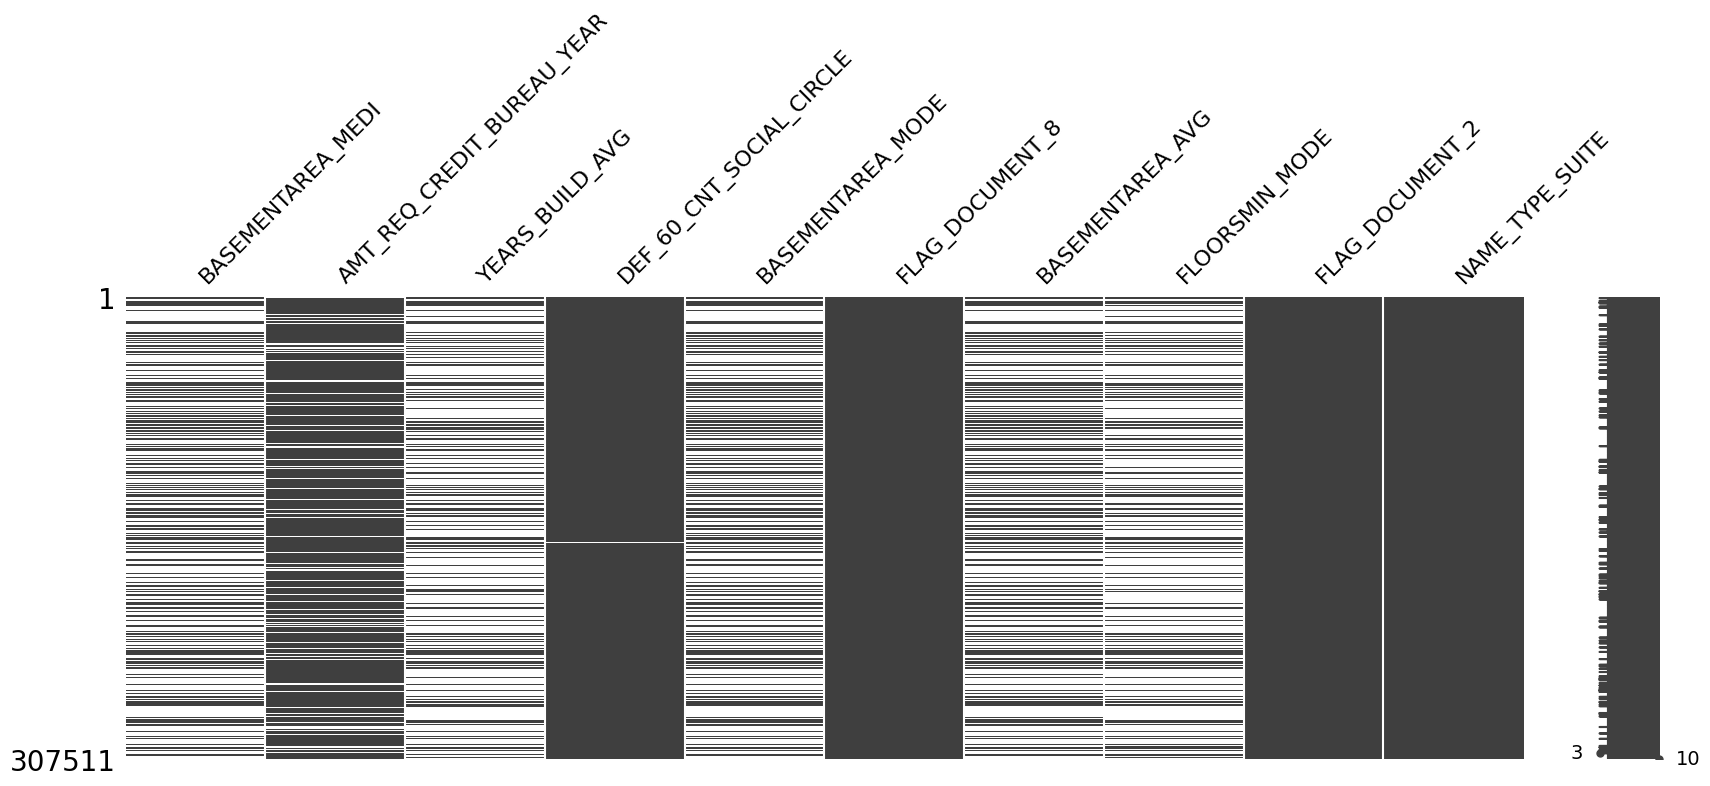

In [5]:
#Useful representation of missing data in dataset
random_columns = app_train.sample(n=10, axis=1)
mno.matrix(random_columns, figsize = (20, 6))

In [6]:
#Selecting only numeric data to impute
app_train_numeric = app_train.select_dtypes(include=['number'])

The percentage of rows with some missing values:  0.0 %


<Axes: >

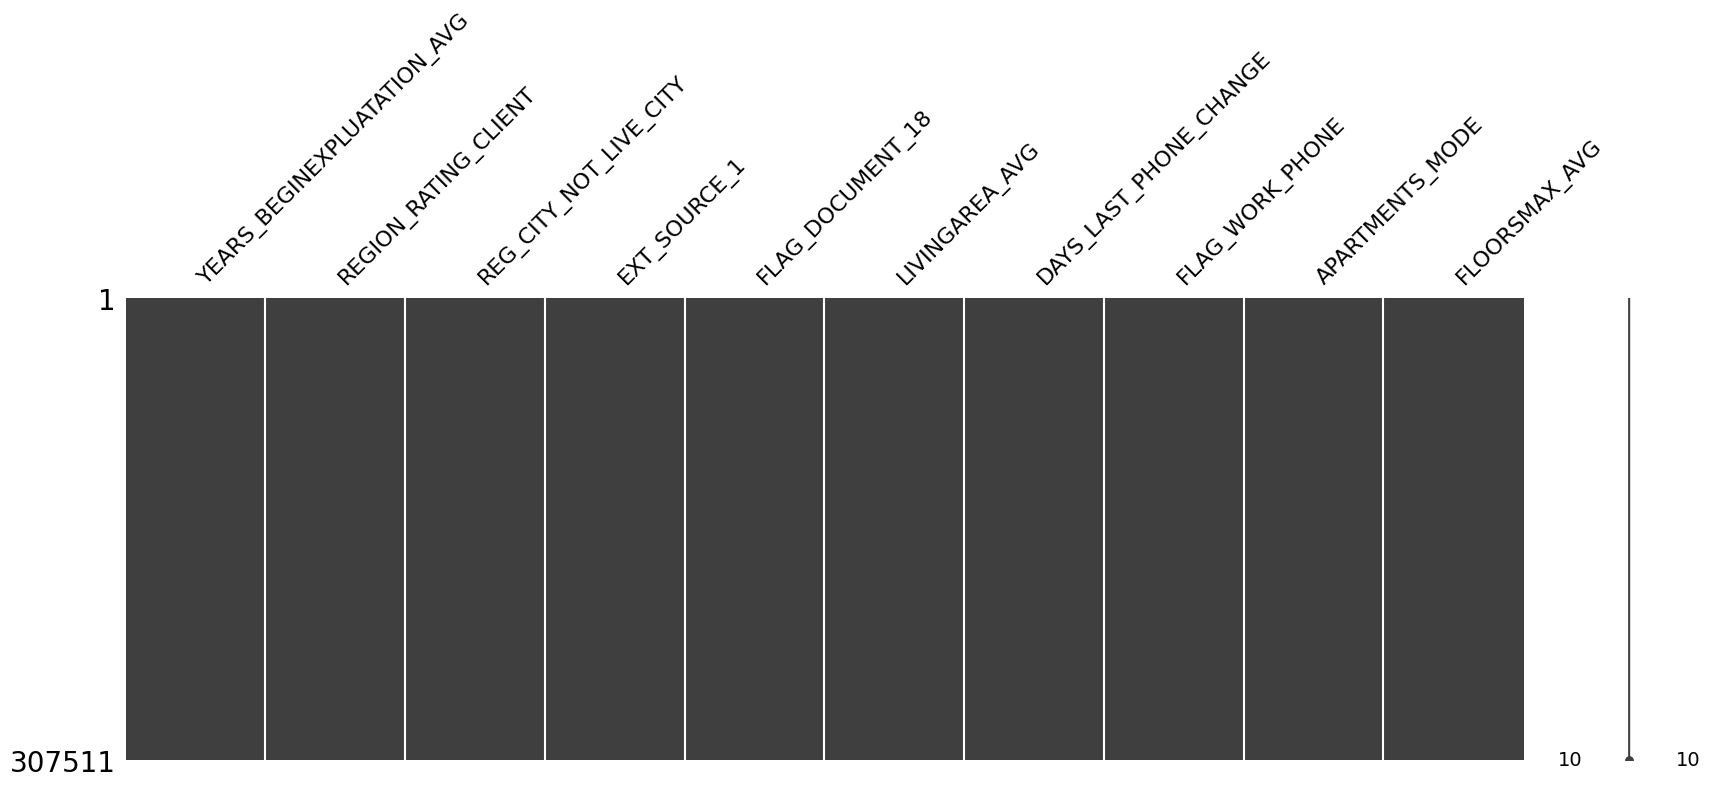

In [7]:
#Mean Imputation
imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(app_train_numeric), columns=app_train_numeric.columns)
missing_imputed = 100*(df_imputed.isnull().sum(axis = 1) > 0).sum()/len(df_imputed)
print("The percentage of rows with some missing values: ", missing_imputed,"%")
random_columns = df_imputed.sample(n=10, axis=1)
mno.matrix(random_columns, figsize = (20, 6))

In [9]:
#K Nearest Neighbor Matching Imputation - Computationally Intensive
knn_imputer = KNNImputer(n_neighbors=2)
df_imputed_knn = pd.DataFrame(knn_imputer.fit_transform(app_train_numeric), columns=app_train_numeric.columns)
missing_imputed = 100*(df_imputed_knn.isnull().sum(axis = 1) > 0).sum()/len(df_imputed_knn)
print("The percentage of rows with some missing values: ", missing_imputed,"%")
random_columns = df_imputed_knn.sample(n=10, axis=1)
mno.matrix(random_columns, figsize = (20, 6))

KeyboardInterrupt: 

In [27]:
#Implementing a code here from https://www.kaggle.com/code/shashankasubrahmanya/missing-data-imputation-using-regression for regression imputation
missing_columns = app_train_numeric.columns[app_train_numeric.isnull().any()].tolist()
print(missing_columns)

['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'TOTALAREA_MODE

In [28]:
def random_imputation(df, feature):

    number_missing = df[feature].isnull().sum()
    observed_values = df.loc[df[feature].notnull(), feature]
    df.loc[df[feature].isnull(), feature + '_imp'] = np.random.choice(observed_values, number_missing, replace = True)
    
    return df

for feature in missing_columns:
    app_train_numeric[feature + '_imp'] = app_train_numeric[feature]
    app_train_numeric = random_imputation(app_train_numeric, feature)

In [34]:
deter_data = pd.DataFrame(columns = ["Det" + name for name in missing_columns])

for feature in missing_columns:
        
    deter_data["Det" + feature] = app_train_numeric[feature + "_imp"]
    parameters = list(set(app_train_numeric.columns) - set(missing_columns) - {feature + '_imp'})
    
    model = linear_model.LinearRegression()
    model.fit(X = app_train_numeric[parameters], y = app_train_numeric[feature + '_imp'])
    
    deter_data.loc[app_train_numeric[feature].isnull(), "Det" + feature] = model.predict(app_train_numeric[parameters])[app_train_numeric[feature].isnull()]

The percentage of rows with some missing values:  0.0 %


<Axes: >

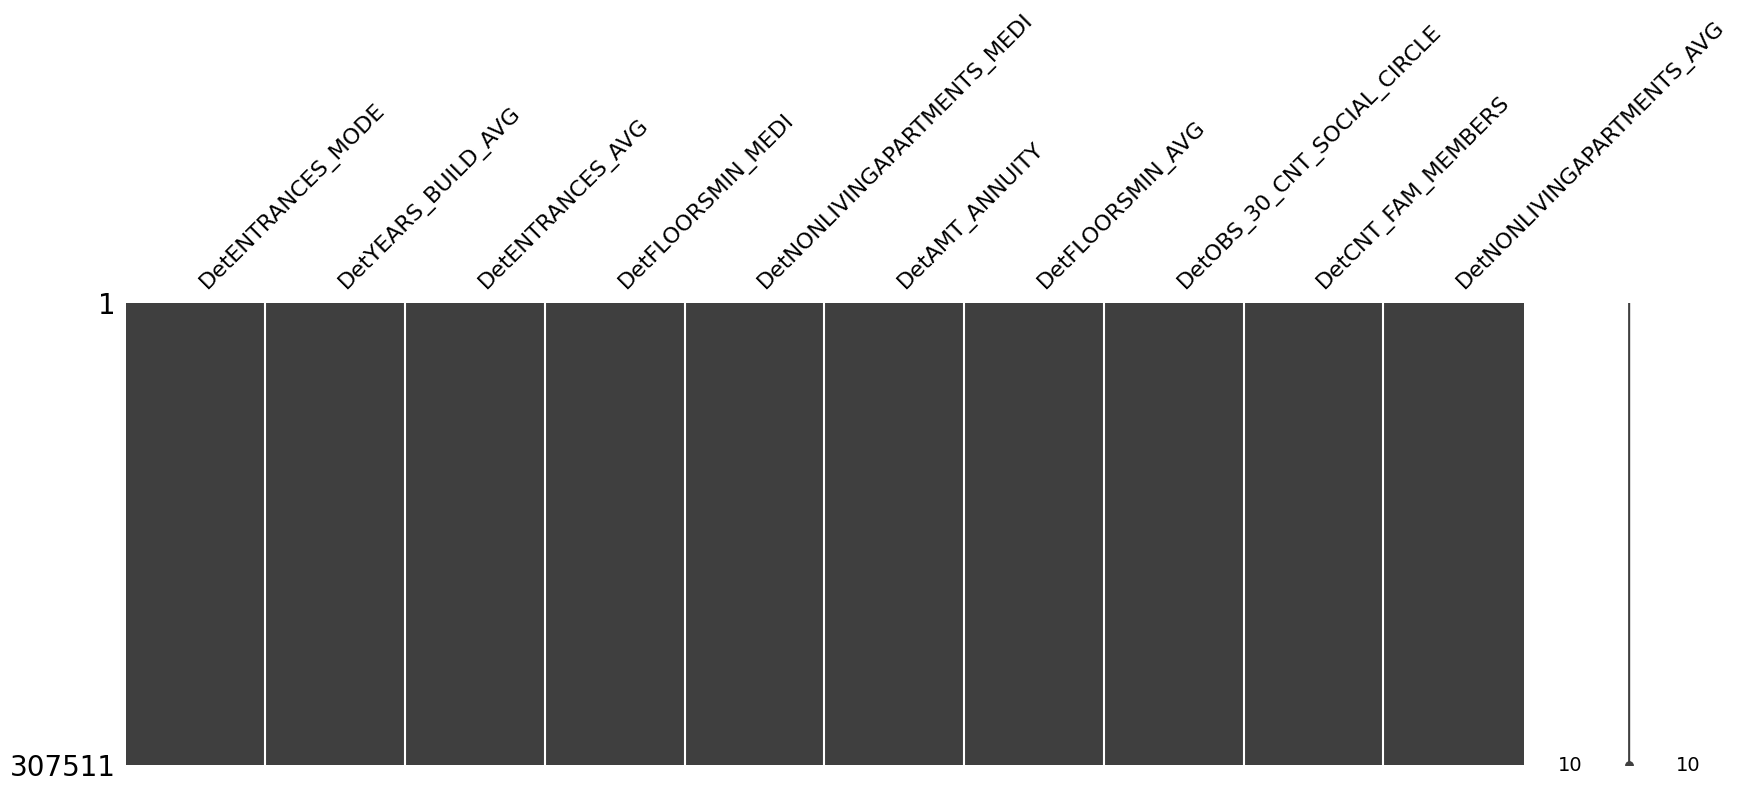

In [35]:
missing_imputed = 100*(deter_data.isnull().sum(axis = 1) > 0).sum()/len(deter_data)
print("The percentage of rows with some missing values: ", missing_imputed,"%")
random_columns = deter_data.sample(n=10, axis=1)
mno.matrix(random_columns, figsize = (20, 6))